In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sqlalchemy import create_engine

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
  postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

engine.dispose()

In [3]:
houseprices

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2010,WD,Normal,142125


In [4]:
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [5]:
# Drop columns with null values
houseprices.drop('id', axis=1, inplace=True)
cols = houseprices.columns
for col in cols:
    if (houseprices[col].isnull().sum() * 100)/len(houseprices) > 0:
        houseprices.drop(col, axis=1, inplace=True)
cols = houseprices.columns
print(len(houseprices.columns))

61


In [6]:
numeric_cols = []
for col in cols:
    if (houseprices[col].dtype == 'int64') or (houseprices[col].dtype == 'float64'):
        numeric_cols.append(col)
print(numeric_cols)
print(len(numeric_cols))

['mssubclass', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']
34


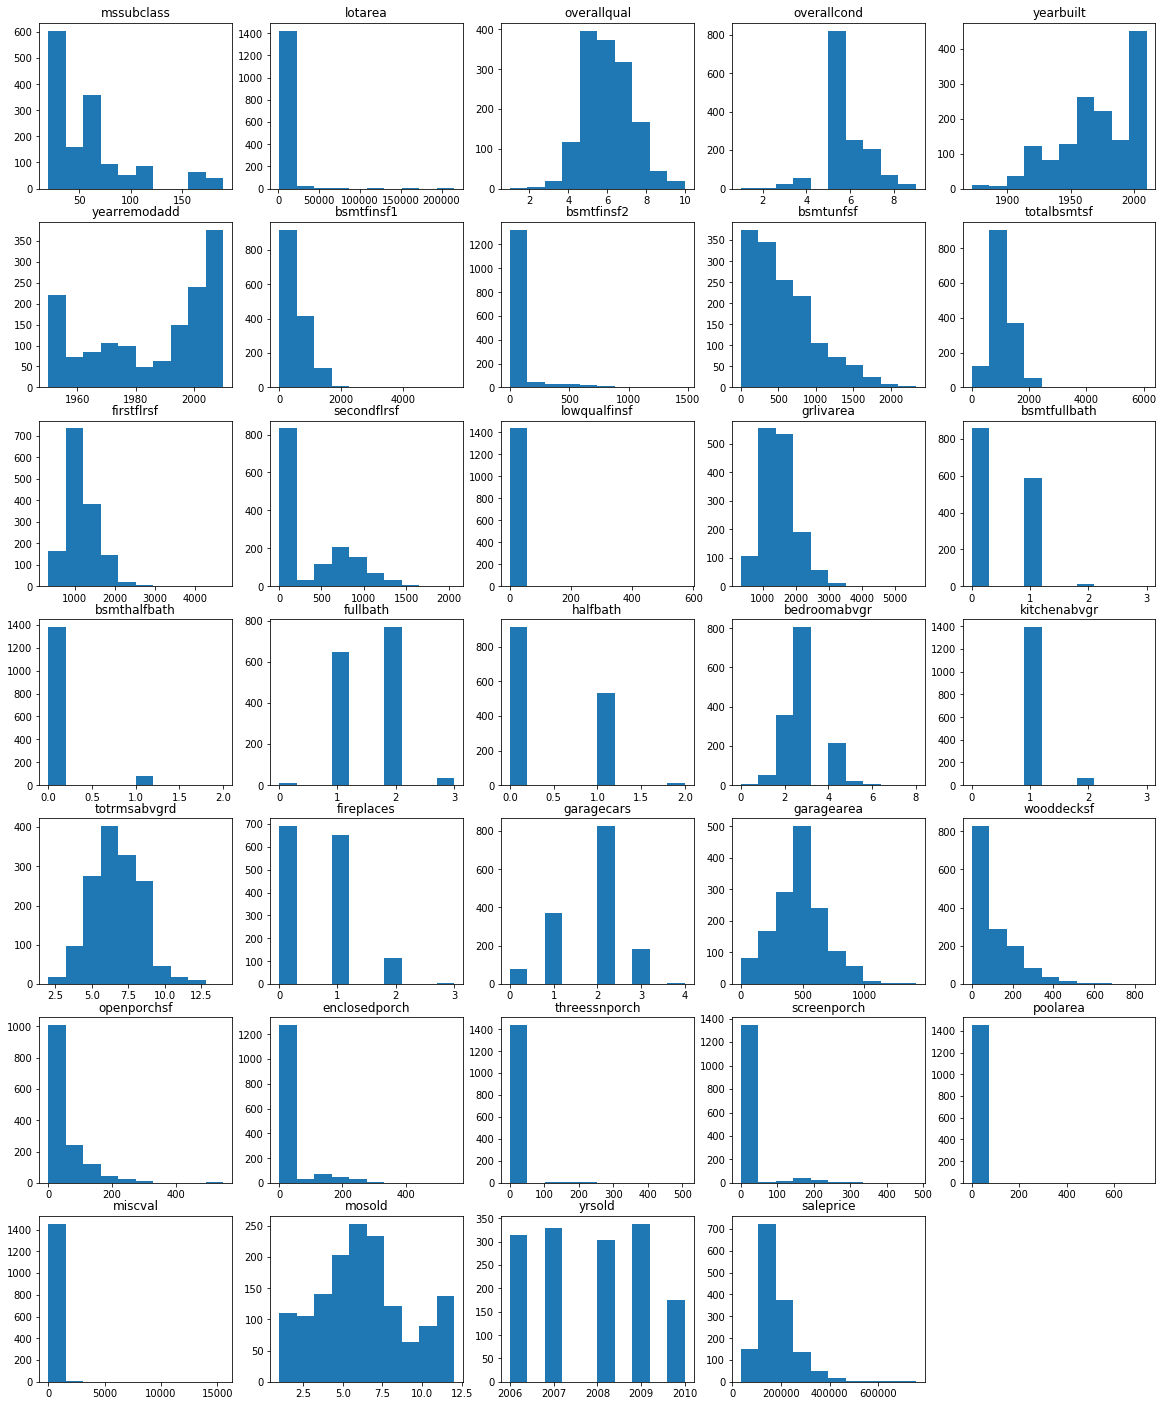

In [7]:
# Univariate analysis with histograms
num_df = houseprices[numeric_cols]
fig = plt.subplots(figsize=(20,25))
for x in range(len(numeric_cols)):
    plt.subplot(7, 5, x+1)
    plt.hist(num_df.iloc[:, x])
    plt.title('{}'.format(numeric_cols[x]))

In [8]:
# Move target column to front
y = houseprices['saleprice']
num_df.drop('saleprice', axis=1, inplace=True)
num_df.insert(0, 'saleprice', y)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


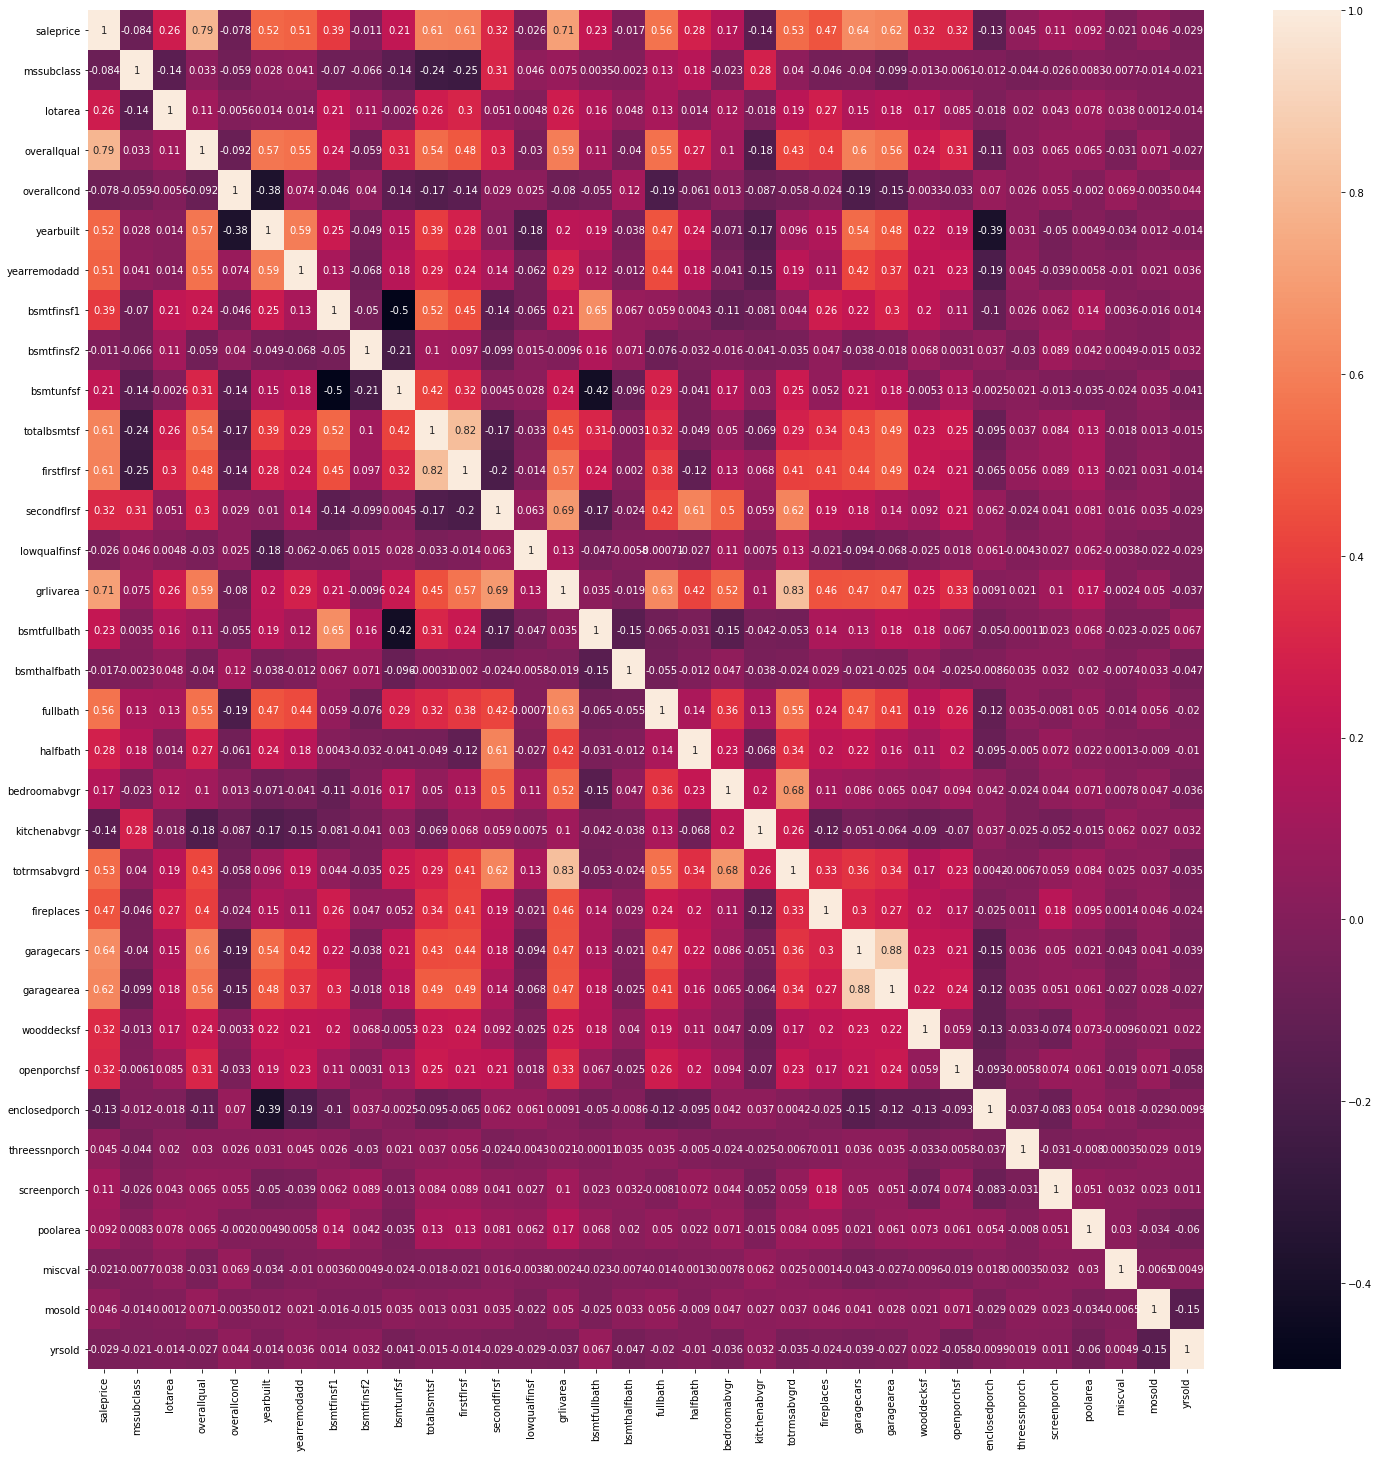

In [9]:
# heatmap of feature correlations
fig = plt.subplots(figsize=(25,25))
num_corr = num_df.corr()
sns.heatmap(num_corr, annot=True)

In [10]:
# Populate list with all numeric columns and remove any that are too closely correlated

features = list(num_corr.columns)
print('original feature length: {}'.format(len(features)))

# Loops to check correlation under diagonal (where columns correlate with themselves)
for x in range(0, len(num_corr.columns), 1):
    col =  abs(num_corr.iloc[(x+1):, x]).sort_values(ascending=False)
    for y in range(len(col)):
        if col[y] > .700:
            if col.index[y] in features:
                features.remove(col.index[y])
#if 'saleprice' not in features:
#    features.append('saleprice')
print('new feature length: {}'.format(len(features)))

original feature length: 34
new feature length: 29


In [11]:
# update numeric dataframe with columns that arent closely correlated
num_df = num_df[features]


# make a dataframe of non-numeric columns
nonum_list = []
for col in cols:
    if col not in num_corr.columns: # num_corr chosen because it contains all numeric value columns
        nonum_list.append(col)
        
nonum_df = houseprices[nonum_list]

In [12]:
# Select features from both numeric and non-numeric columns and add to main features list
new_corr = num_df.corr()

feats_list = []
sale = abs(new_corr.loc[:, 'saleprice']).sort_values(ascending=False)
for x in new_corr.columns:
    if x != 'saleprice':
        if sale[x] > .5000:
            feats_list.append(x)

for x in nonum_df.columns:
    if len(nonum_df[x].unique()) < 5:
        feats_list.append(x)

In [13]:
# Make dataframe of feats_list and convert non-numeric columns to dummy columns (turn categories to binary values)
feats_df = houseprices[feats_list]
for col in feats_df.columns:
    if col in nonum_df.columns:
        dum_df = pd.get_dummies(feats_df[col], prefix= col, drop_first=True)
        feats_df = pd.concat([feats_df, dum_df], axis=1)
        feats_df.drop(col, axis=1, inplace=True)

In [14]:
# Fit with ordinary least squares method
y = houseprices.saleprice
X = feats_df


X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size= .2)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sat, 20 Jun 2020   Prob (F-statistic):          1.13e-308
Time:                        16:16:36   Log-Likelihood:                -14062.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1143   BIC:                         2.830e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5.036e+04   1.89e+05     -0.267      0.790   -4.21e+05     3.2e+05
yearbuilt         -138.6535     63.189     -2.194      0.028    -262.634     -14.673
yearremodadd       217.8207     89.578      2.432      0.015      42.064     393.577
totalbsmtsf         43.2024      3.366     12.834      0.000      36.598      49.807
fullbath          2.908e+04   2778.329     10.466      0.000    2.36e+04    3.45e+04
garagecars        2.589e+04   2174.055     11.908      0.000    2.16e+04    3.02e+04
street_Pave       2.581e+04    2.2e+04      1.171      0.242   -1.74e+04     6.9e+04
lotshape_IR2      7485.9350   7560.675      0.990      0.322   -7348.424    2.23e+04
lotshape_IR3     -3.312e+04   1.53e+04     -2.169      0.030   -6.31e+04   -3154.684
lotshape_Reg     -1.162e+04   2724.310     -4.265      0.000    -1.7e+04   -6273.988
landcontour_HLS   2.872e+04   9536.244      3.011      0.003       1e+04    4.74e+04
landcontour_Low   1.704e+04   1.13e+04      1.511      0.131   -5084.058    3.92e+04
landcontour_Lvl   1.051e+04   6874.817      1.528      0.127   -2983.642     2.4e+04
utilities_NoSeWa -1.686e+04   4.17e+04     -0.404      0.686   -9.87e+04     6.5e+04
landslope_Mod     1.864e+04   7345.710      2.538      0.011    4228.817    3.31e+04
landslope_Sev      3.53e+04    1.6e+04      2.200      0.028    3811.611    6.68e+04
exterqual_Fa     -8.536e+04    1.7e+04     -5.024      0.000   -1.19e+05    -5.2e+04
exterqual_Gd     -4.423e+04   7829.830     -5.649      0.000   -5.96e+04   -2.89e+04
exterqual_TA     -6.956e+04   8615.523     -8.073      0.000   -8.65e+04   -5.27e+04
centralair_Y      1.527e+04   5810.214      2.629      0.009    3873.168    2.67e+04
kitchenqual_Fa   -5.936e+04   1.08e+04     -5.491      0.000   -8.06e+04   -3.81e+04
kitchenqual_Gd   -5.418e+04   5871.348     -9.227      0.000   -6.57e+04   -4.27e+04
kitchenqual_TA   -6.373e+04   6692.848     -9.522      0.000   -7.69e+04   -5.06e+04
paveddrive_P      1.138e+04   1.05e+04      1.081      0.280   -9278.134     3.2e+04
paveddrive_Y      5617.4034   5919.953      0.949      0.343   -5997.791    1.72e+04
==============================================================================
Omnibus:                      396.964   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7933.923
Skew:                           1.059   Prob(JB):                         0.00
Kurtosis:                      15.591   Cond. No.                     4.67e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+05. This might indicate that there are
strong multicollinearity or other numerical pr

In [15]:
# make a list of only the columns with the lowest p-values (p-values determine whether data was due to natural random noise)
keep_feats = []
for x in range(len(results.pvalues)):
    if results.pvalues.sort_values(ascending=False)[x] < .05:                         # p-value of 5% as threshold
        if results.pvalues.sort_values(ascending=False).index[x] != 'const':
            keep_feats.append(results.pvalues.sort_values(ascending=False).index[x])
print(keep_feats)

['lotshape_IR3', 'yearbuilt', 'landslope_Sev', 'yearremodadd', 'landslope_Mod', 'centralair_Y', 'landcontour_HLS', 'lotshape_Reg', 'exterqual_Fa', 'kitchenqual_Fa', 'exterqual_Gd', 'exterqual_TA', 'kitchenqual_Gd', 'kitchenqual_TA', 'fullbath', 'garagecars', 'totalbsmtsf']


In [16]:
# Run new OLS model using only the features with low p-values
X = feats_df[keep_feats]

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size= .2)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

results2 = sm.OLS(Y_train, X_train).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     178.4
Date:                Sat, 20 Jun 2020   Prob (F-statistic):          1.24e-307
Time:                        16:16:36   Log-Likelihood:                -14066.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1150   BIC:                         2.826e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.149e+05   1.86e+05     -0.617      0.537   -4.81e+05    2.51e+05
lotshape_IR3     -5.84e+04    1.5e+04     -3.900      0.000   -8.78e+04    -2.9e+04
yearbuilt         -82.6153     60.774     -1.359      0.174    -201.857      36.626
landslope_Sev    1.488e+04   1.28e+04      1.163      0.245   -1.02e+04       4e+04
yearremodadd      226.6962     87.078      2.603      0.009      55.846     397.546
landslope_Mod    1.298e+04   6064.976      2.141      0.032    1085.030    2.49e+04
centralair_Y     1.648e+04   5473.341      3.011      0.003    5740.339    2.72e+04
landcontour_HLS  1.189e+04   6796.312      1.749      0.081   -1447.574    2.52e+04
lotshape_Reg    -1.314e+04   2692.691     -4.881      0.000   -1.84e+04   -7859.637
exterqual_Fa    -8.348e+04   1.64e+04     -5.092      0.000   -1.16e+05   -5.13e+04
kitchenqual_Fa  -7.065e+04   1.06e+04     -6.638      0.000   -9.15e+04   -4.98e+04
exterqual_Gd    -4.387e+04   8174.123     -5.367      0.000   -5.99e+04   -2.78e+04
exterqual_TA    -7.074e+04   8894.437     -7.954      0.000   -8.82e+04   -5.33e+04
kitchenqual_Gd  -6.296e+04   6066.619    -10.379      0.000   -7.49e+04   -5.11e+04
kitchenqual_TA  -7.374e+04   6843.383    -10.775      0.000   -8.72e+04   -6.03e+04
fullbath          2.57e+04   2709.272      9.484      0.000    2.04e+04     3.1e+04
garagecars       2.389e+04   2106.533     11.339      0.000    1.98e+04     2.8e+04
totalbsmtsf        39.2669      3.346     11.734      0.000      32.701      45.832
==============================================================================
Omnibus:                      367.284   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8836.384
Skew:                           0.883   Prob(JB):                         0.00
Kurtosis:                      16.359   Cond. No.                     4.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
y_predict = results2.predict(X_test)

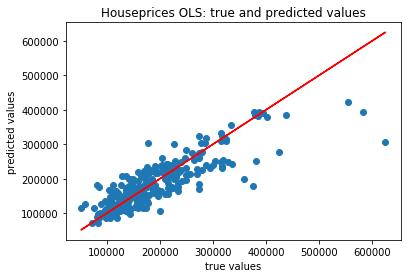

Mean absolute error of the prediction is: 30529.82629480621
Mean squared error of the prediction is: 2065002770.6587465
Root mean squared error of the prediction is: 45442.30155547523
Mean absolute percentage error of the prediction is: 16.905710191410023


In [18]:
plt.scatter(Y_test, y_predict)
plt.plot(Y_test, Y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Houseprices OLS: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_predict)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_predict)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_predict)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_predict) / Y_test)) * 100))

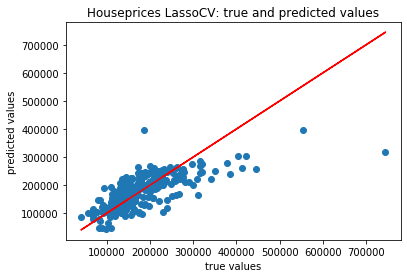

Mean absolute error of the prediction is: 39493.182675454
Mean squared error of the prediction is: 3099650790.584366
Root mean squared error of the prediction is: 55674.507546850975
Mean absolute percentage error of the prediction is: 23.287132709398048


In [19]:
# Lasso 5 fold  CV
X = feats_df[keep_feats]
y = houseprices.saleprice

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size= .2)

result_lass = LassoCV(cv=5).fit(X_train, Y_train)
y_predict_train = result_lass.predict(X_train)
y_predict_test = result_lass.predict(X_test)

plt.scatter(Y_test, y_predict_test)
plt.plot(Y_test, Y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Houseprices LassoCV: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_predict_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_predict_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_predict_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_predict_test) / Y_test)) * 100))

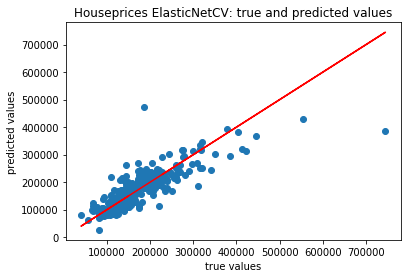

Mean absolute error of the prediction is: 29018.608435495258
Mean squared error of the prediction is: 2011940902.855557
Root mean squared error of the prediction is: 44854.664226316054
Mean absolute percentage error of the prediction is: 17.193999277857134


In [20]:
# Ridge 5 fold CV
result_ridge = RidgeCV(cv=5).fit(X_train, Y_train)
y_predict_train = result_ridge.predict(X_train)
y_predict_test = result_ridge.predict(X_test)

plt.scatter(Y_test, y_predict_test)
plt.plot(Y_test, Y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Houseprices ElasticNetCV: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_predict_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_predict_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_predict_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_predict_test) / Y_test)) * 100))

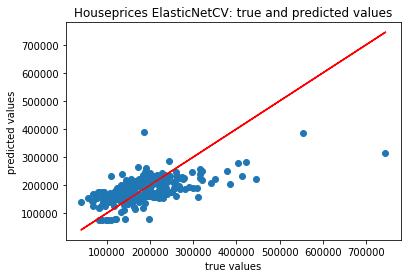

Mean absolute error of the prediction is: 46339.66434319764
Mean squared error of the prediction is: 3768436842.168395
Root mean squared error of the prediction is: 61387.59518150548
Mean absolute percentage error of the prediction is: 29.296673031904184


In [21]:
# Elastic Net 5 fold CV
result_EN = ElasticNetCV(cv=5).fit(X_train, Y_train)
y_predict_train = result_EN.predict(X_train)
y_predict_test = result_EN.predict(X_test)

plt.scatter(Y_test, y_predict_test)
plt.plot(Y_test, Y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Houseprices ElasticNetCV: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_predict_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_predict_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_predict_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_predict_test) / Y_test)) * 100))